In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="dark")
%matplotlib inline
''' %matplotlib inline sets the backend of matplotlib to
the 'inline' backend. When using the 'inline' backend,
your matplotlib graphs will be included in your notebook,
next to the code.'''

import  torch
import torch.nn.functional as F
'''
To get same results when sampling during different runs.
If you are using cuDNN, you should set the deterministic behavior.
This might make your code quite slow, but might be a good method to check your code and deactivate it later.
'''
torch.backends.cudnn.deterministic = True

# A multi-character level MLP Language Model
Now here we want to consider a wider range of character inputs to predict the next character!

Benjio et al 2003 (MLP LM) was proposed a LM for words, we use it for characters:

    1- bc of the exponentially growing number of states as we increase the number of input chunks of words & characters, (like for 2 characters we had 27 * 27, for 3 char it will be  27**3 and so on!!), we can't continue with the probabilistic approach anymore, but we scale the NN.

    2- we are going to embed each word or character to a latent vector (embedding).
    
    3- This is a cool idea and allow us for out-of distribution generalization:
    
        3.1- During test time, the network might encounter inputs that has never exactly seen during in the empirical dataset (out-of-empirical-distribution).

        3.2 but if we train the network to put similar words or characters embeddings close together, then for example if it has seen "A dog is running in a room", it will ba able to change the words or characters with same semantic or grammar rule, and say "A cat is running in a room" or "The cat is running in the room". Even though you have not seen them!

        3.3- we have look up table to map the 27 characters to its multi dimensional embedding index

In [2]:

words = open('names.txt', 'r').read().splitlines()

In [3]:
# sets takes an input, create a set of all items,
# & doesn't allow duplicates :)
# then we want a sorted list of course, the order matters! 
chars = sorted(list(set(''.join(words))))
# a map or dict:
# start from 1
s_to_i = { s:i for i, s in enumerate(chars, start=1)}
s_to_i['.'] = 0
i_to_s = { i:s for s,i in s_to_i.items()}

In [4]:
import itertools
def plot_heatmap(tensor, nrow=None, ncol=None, fig_size=(10,10)):
    if (nrow is None) or (ncol is None):
        nrow = tensor.shape[0]
        ncol = tensor.shape[1]
    plt.figure(figsize=fig_size)
    plt.imshow(tensor.detach().numpy(), cmap= 'Blues')
    # manually write text on each cell (seaborn annot doesn't look good)
    for i, j in itertools.product(range(nrow), range(ncol)):
        # x:col, y:rows, the origin is top left corner, makes bottom <->top
        plt.text(x=j, y=i, s=f'{tensor[i,j].item():.2f}', ha='center', va='center', color='grey')
    plt.axis('off')

## Splitting dataset into Training Dev & Test sets

1. split rate 80%, 10%, 10%

2. Dev or Validation set is for hyper parameter tuning

3. test should be touched at he end

In [6]:
WINDOW_SIZE = 4

def build_dataset(words:list, type:str):
    xs, ys = [], []

    # context input window: how many characters do we take to predict the next one?
    

    for w in words:
        context_window = [0]*WINDOW_SIZE
        for ch in f'{w}.':
            idx_y = s_to_i[ch]
            ys.append(idx_y)

            xs.append(context_window) # input : ch1
            # print(''.join(i_to_s[i] for i in context_window) + f' ---> {ch}' )

            # shift_to_left context window and append the idx_y
            context_window = context_window[1:] + [idx_y]
    xs = torch.tensor(xs)
    # ys = torch.Tensor(ys)
    ys = torch.tensor(ys)
    print(f'{type}: {xs.shape = }')
    return xs, ys


import random
random.seed(42)
random.shuffle(words)
n80 = int( 0.8*len(words) )
n90 = int( 0.9*len(words) )
Xtr, Ytr = build_dataset(words[:n80], 'Tr')
Xdev, Ydev = build_dataset(words[n80:n90], 'Dev')
Xts, Yts = build_dataset(words[n90:], 'Ts')
TR_SIZE = Xtr.shape[0]
DEV_SIZE = Xdev.shape[0]
TS_SIZE = Xts.shape[0]
print(f'{TR_SIZE = }')
print(f'{WINDOW_SIZE = }')
NCLASS = 27
print(f'{NCLASS = }')

Tr: xs.shape = torch.Size([182580, 4])
Dev: xs.shape = torch.Size([22767, 4])
Ts: xs.shape = torch.Size([22799, 4])
TR_SIZE = 182580
WINDOW_SIZE = 4
NCLASS = 27


## The summary of parameters

In [10]:
EMB_DIM = 2
HLAYER_SIZE = 100

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g)
b1 = torch.randn( HLAYER_SIZE, generator=g)
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g)
b2 = torch.randn( NCLASS, generator=g)
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

3681

## Training loop with PyTorch Functional

### the loop

In [11]:
lr = 0.1
BATCH_SIZE = 32
NSTEPS = 100000

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    h = torch.tanh(emb.view(BATCH_SIZE, -1)@W1 + b1 ) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    # counts = logits.exp() # * equivalent to counts [b, NCLASS]
    # probs = counts / counts.sum(dim=1 , keepdim=True) #[b, NCLASS]
     
    # loss = -probs[torch.arange(BATCH_SIZE), ys].log().mean() + l2coef*(W**2).mean()

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])

    # for p in parameters:
    #     p.grad = None
    loss_mini.backward()

    # update &
    # set the weight grads to None, PyTorch interpret it as 0
    # but None is more efficient
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')

# print(f'loss_mini: {loss_mini.item()}')

loss: 2.2109198570251465


## Evaluating hyper-parameters with Dev set

### loss evaluation function

In [ ]:
# This decorator disables gradient tracking for final training, dev, and test evaluation
# we don't optimize here
@torch.no_grad()
def evaluate_loss(ds_type): # ds_type: dataset type
    X,Y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xts, Yts),
    }[ds_type]

    emb = emb_lkt[X] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    h = torch.tanh(emb.view(-1, WINDOW_SIZE*EMB_DIM)@W1 + b1 ) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    
    loss = F.cross_entropy(logits, Y)
    print(f'{ds_type} loss: {loss.item()}')


1- if the training loss is roughly equal (.2f) to the dev loss, it means the model is under-fitted. it's not big enough to just purely memorizes the data. so we can scale the model and increase the number of parameters, meaning the size of hidden layer and embeddings.

2- On the other side, if your overfitting to traing data set, it means the model is to big and over-parameterized. so you have 2 options find a larger dataset, or lower the number of parameters.

Also tune the lr here! first continue with 0.1 till you don't improvement in the total train loss then go with 0.01 and lower. see the dev_loss as well.

### increasing the size of Hidden Layer
Also tune the lr here! first continue with 0.1 till you don't improvement in the total train loss then go with 0.01 and lower. see the dev_loss as well.

In [ ]:
EMB_DIM = 2
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g)
b1 = torch.randn( HLAYER_SIZE, generator=g)
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g)
b2 = torch.randn( NCLASS, generator=g)
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

10881

In [ ]:
lri = []
lr_expo = torch.linspace(start=-3, end=0, steps=1000)
exponential_lr = 10**lr_expo

In [ ]:
BATCH_SIZE = 32
loglossi = []
stepi = []

NSTEPS = 10000

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    h = torch.tanh(emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)@W1 + b1 ) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    # counts = logits.exp() # * equivalent to counts [b, NCLASS]
    # probs = counts / counts.sum(dim=1 , keepdim=True) #[b, NCLASS]
     
    # loss = -probs[torch.arange(BATCH_SIZE), ys].log().mean() + l2coef*(W**2).mean()

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    
    loglossi.append(loss_mini.log10().item())
    stepi.append(i)

    # lr exploration
    lr = exponential_lr[i]
    lri.append(lr_expo[i]) # store the exponent
    # # after finding the lr
    # lr = 0.1


    loss_mini.backward()

    # update &
    # set the weight grads to None, PyTorch interpret it as 0
    # but None is more efficient
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')

# print(f'loss_mini: {loss_mini.item()}')

loss_mini: 1.905316710472107


In [ ]:
evaluate_loss('train')
evaluate_loss('dev')

In [ ]:
plt.plot(lri, loglossi)

In [ ]:
plt.plot(stepi, loglossi)

### Embedding Visualization

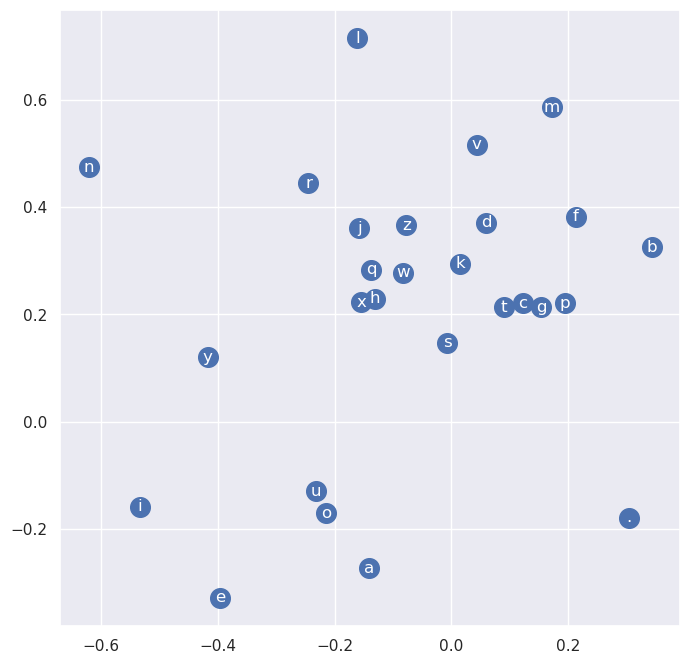

In [24]:
plt.figure(figsize=(8,8))
plt.scatter(x= emb_lkt[:,0].data, y=emb_lkt[:,1].data, s=200)
for i in range(NCLASS):
    plt.text(x=emb_lkt[i,0].item(), y=emb_lkt[i,1].item(), s=i_to_s[i], ha='center', va='center', color='white')
plt.grid('minor')

### increasing the size of Embeddings
Also tune the lr here! first continue with 0.1 till you don't improvement in the total train loss then go with 0.01 and lower. see the dev_loss as well.

In [ ]:
EMB_DIM = 10
HLAYER_SIZE = 300

g = torch.Generator().manual_seed(2147483647)
emb_lkt = torch.randn( NCLASS, EMB_DIM, generator=g)
W1 = torch.randn( WINDOW_SIZE*EMB_DIM, HLAYER_SIZE , generator=g)
b1 = torch.randn( HLAYER_SIZE, generator=g)
W2 = torch.randn( HLAYER_SIZE, NCLASS, generator=g)
b2 = torch.randn( NCLASS, generator=g)
parameters = [emb_lkt, W1, b1, W2, b2]
for p in parameters:
    p.requires_grad = True
    p.grad = None
sum(p.nelement() for p in parameters)

10881

In [ ]:
lri = []
lr_expo = torch.linspace(start=-3, end=0, steps=1000)
exponential_lr = 10**lr_expo

BATCH_SIZE = 32
loglossi = []
stepi = []

NSTEPS = 10000

for i in range(NSTEPS):
    
    # Forward path
    mini_batch_idx = torch.randint(low=0, high=TR_SIZE, size=(BATCH_SIZE,))
    emb = emb_lkt[Xtr[mini_batch_idx]] # BATCH_SIZE, WINDOW_SIZE, emb_dim
    h = torch.tanh(emb.view(BATCH_SIZE, WINDOW_SIZE*EMB_DIM)@W1 + b1 ) # BATCH_SIZE, hlayer_size
    logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
    # counts = logits.exp() # * equivalent to counts [b, NCLASS]
    # probs = counts / counts.sum(dim=1 , keepdim=True) #[b, NCLASS]
     
    # loss = -probs[torch.arange(BATCH_SIZE), ys].log().mean() + l2coef*(W**2).mean()

    loss_mini = F.cross_entropy(logits, Ytr[mini_batch_idx])
    
    loglossi.append(loss_mini.log10().item())
    stepi.append(i)

    lr = exponential_lr[i]
    lri.append(lr_expo[i]) # store the exponent

    loss_mini.backward()

    # update &
    # set the weight grads to None, PyTorch interpret it as 0
    # but None is more efficient
    for p in parameters:
        p.data -= lr*p.grad
        p.grad = None

    # track stats
    if i % 10000 == 0:
        print(f'iteration: {i:7d} / {NSTEPS:7d} | mini loss: {loss_mini.item():.4f}')

# print(f'loss_mini: {loss_mini.item()}')

loss_mini: 1.905316710472107


In [ ]:
evaluate_loss('train')
evaluate_loss('dev')

In [ ]:
plt.plot(lri, loglossi)

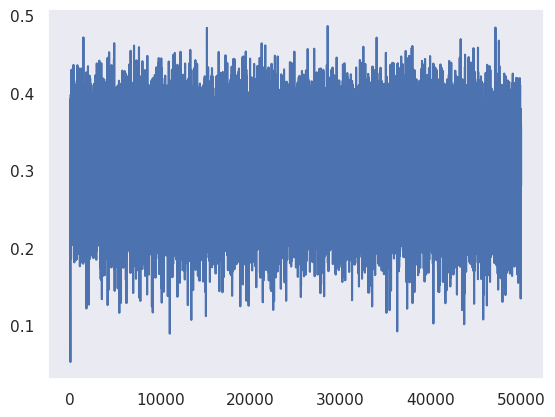

In [51]:
plt.plot(stepi, loglossi)

## Let's Generate some samples like Bigram

In [56]:

g = torch.Generator().manual_seed(2147483647)
for _ in range(10):
    idx_y = 0
    name = ''
    context_window = [0]*WINDOW_SIZE
    
    while True:
        # Forward path
        emb = emb_lkt[torch.tensor([context_window])] # BATCH_SIZE=1, WINDOW_SIZE, emb_dim
        h = torch.tanh(emb.view(-1, WINDOW_SIZE*EMB_DIM)@W1 + b1 ) # BATCH_SIZE, hlayer_size
        logits = h @ W2 + b2 # * log counts [BATCH_SIZE, NCLASS]
        probs = F.softmax(logits, dim=1)
        
        idx_y = torch.multinomial(probs.detach(), num_samples=1, replacement=True, generator=g).item()
        # shift_to_left context window and append the idx_y
        context_window = context_window[1:] + [idx_y]
        if idx_y == 0:
            break
        ch = i_to_s[idx_y]
        # print(ch)
        name += ch
    print(name)

mila
uvannecterry
graisen
blicha
maryens
rikal
clarel
daltie
destmauland
futhi
